# Accident-Eye:hybrid CNN-XGBoost model
------------------------------------------------

### Install tensorflow

In [1]:
pip install tensorflow==2.15

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.0
[notice] To update, run: c:\Users\amal_\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


#### Imports TensorFlow

In [2]:
import tensorflow as tf

print(tf.__version__)



2.15.0


### Loading and Preprocessing Training Images

In [3]:
import os
import cv2
import numpy as np

# Create lists to store image data and labels
data = []  # List to store image data
labels = []  # List to store corresponding labels

# Define classes (folder names)
classes = ['NonAccident', '3', '1', '2']

# Iterate through each class (folder)
for class_name in classes:
    class_path = os.path.join('Dataset/train', class_name)
    # Iterate through each image file in the class folder
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):  # Check if the file is a PNG image
            # Read the image using OpenCV
            img = cv2.imread(os.path.join(class_path, filename))
            # Resize the image to a common size (64x64 pixels)
            img = cv2.resize(img, (320, 320))
            # Append the image data to the 'data' list
            data.append(img)
            # Append the corresponding label (index of the class in 'classes') to the 'labels' list
            labels.append(classes.index(class_name))

# Convert the lists to NumPy arrays for further processing
data = np.array(data)
labels = np.array(labels)


#### Loading and Preprocessing Test Images

In [4]:
import os
import cv2
import numpy as np

# Create lists to store image data and labels
dataVal = []  # List to store image data
labelsVal = []  # List to store corresponding labels

# Define classes (folder names)
classes = ['NonAccident', '3', '1', '2']

# Iterate through each class (folder)
for class_name in classes:
    class_path = os.path.join('Dataset/test', class_name)
    # Iterate through each image file in the class folder
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):  # Check if the file is a PNG image
            # Read the image using OpenCV
            img = cv2.imread(os.path.join(class_path, filename))
            # Resize the image to a common size (64x64 pixels)
            img = cv2.resize(img, (320, 320))
            # Append the image data to the 'data' list
            dataVal.append(img)
            # Append the corresponding label (index of the class in 'classes') to the 'labels' list
            labelsVal.append(classes.index(class_name))

# Convert the lists to NumPy arrays for further processing
dataVal = np.array(dataVal)
labelsVal = np.array(labelsVal)


### Normalization and label One-Hot Encoding

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Normalize pixel values
X_train = data.astype('float32') / 255.0
X_test = dataVal.astype('float32') / 255.0


# Convert labels to one-hot encoding
y_train = to_categorical(labels, num_classes=len(classes))
y_test = to_categorical(labelsVal, num_classes=len(classes))



-------------------
# Features extraction

In [6]:
from keras.models import load_model
from keras.models import Model
from xgboost import XGBClassifier

# Load your pre-trained CNN model
cnn_model = load_model('cnn_model_320_32.h5')

# Remove the output layer to use it as a feature extractor
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Extract features from your training and testing data
cnn_features_train = cnn_feature_extractor.predict(X_train)
cnn_features_test = cnn_feature_extractor.predict(X_test)




106/106 [==============================] - 447s 4s/step


### Print the length of train featuers

In [7]:
# Get the shape of the extracted features
feature_length = cnn_features_train.shape[1]  # Assuming features are in the second dimension
print("Length of train features:", feature_length)


Length of train features: 128


## PCA

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import h5py

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cnn_features_train)

# Fit PCA on scaled data
pca = PCA()
pca.fit(scaled_data)

PCA()

### Print the the number of components

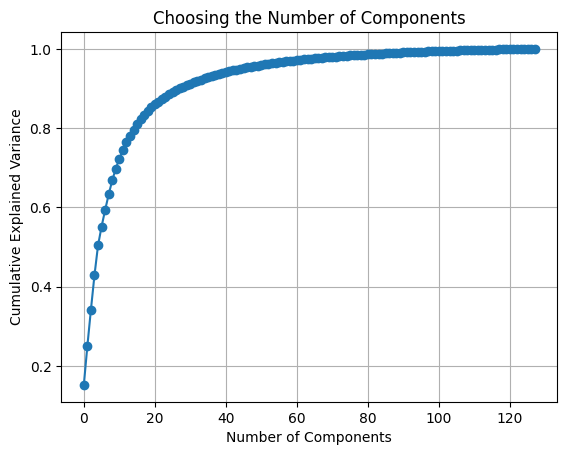

Number of components to retain 95% variance: 46


In [9]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Choosing the Number of Components')
plt.grid()
plt.show()

# Choose components that explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

### Reduce dataset dimension to the new number of components

In [10]:
from sklearn.decomposition import PCA

# Number of components to keep (128 in this case)
n_components = 46

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA to the CNN features from the training data
pca.fit(cnn_features_train)

# Transform the CNN features using PCA for both training and test sets
pca_cnn_features_train = pca.transform(cnn_features_train)
pca_cnn_features_test = pca.transform(cnn_features_test)

---------------------------
 Imports for XGBoost

In [11]:
import optuna
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


c:\Users\amal_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing Data for XGBoost Training and Testing

In [14]:
# Convert one-hot encoded labels to a 1D array of class indices
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Create a mapping for labels (if needed, optional in this case)
unique_labels = np.unique(y_train_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Map labels to numeric format
numeric_labels_train = np.array([label_mapping[label] for label in y_train_labels])
numeric_labels_test = np.array([label_mapping[label] for label in y_test_labels])

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(pca_cnn_features_train, label=numeric_labels_train)
dtest = xgb.DMatrix(pca_cnn_features_test, label=numeric_labels_test)

#### Defines a Watchlist for Evaluation

In [13]:
# Watchlist to evaluate model on training and validation datasets
watchlist = [(dtrain, 'train'), (dtest, 'eval')]


# Bayesian Optimization

In [22]:
# Objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multi:softmax',                                                       # For multi-class classification
        'num_class': len(np.unique(numeric_labels_train)),                                  # Set the number of classes
        'eval_metric': 'mlogloss',                                                          # Multi-class log-loss
        'eta': trial.suggest_float('eta', 0.01, 0.3, step=0.01),                            # Updated learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10),                                 # Updated max depth of trees
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),                  # Updated subsample ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),    # Updated column sample ratio by tree
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),                      # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True)                         # L1 regularization
    }


    # Define the number of boosting rounds to try
    num_boost_round = trial.suggest_int('num_boost_round', 50, 500, step=50)

    # Train the model
    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Validate on validation set
    val_predictions = bst.predict(dtest)
    val_accuracy = accuracy_score(numeric_labels_test, val_predictions)
    
    # Objective is to maximize validation accuracy
    return val_accuracy

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run for 50 trials

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-01-27 20:51:05,111] A new study created in memory with name: no-name-bb65e0dd-7fe1-4492-9718-a58b63c8e479
[I 2025-01-27 20:51:06,100] Trial 0 finished with value: 0.9141249629848979 and parameters: {'eta': 0.14, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.6, 'lambda': 8.822597971475236, 'alpha': 0.48050643383702646, 'num_boost_round': 400}. Best is trial 0 with value: 0.9141249629848979.
[I 2025-01-27 20:51:06,836] Trial 1 finished with value: 0.916790050340539 and parameters: {'eta': 0.22, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.6, 'lambda': 0.0052507109233886455, 'alpha': 3.6237399482443484, 'num_boost_round': 350}. Best is trial 1 with value: 0.916790050340539.
[I 2025-01-27 20:51:09,065] Trial 2 finished with value: 0.9203435001480604 and parameters: {'eta': 0.23, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'lambda': 0.0020594259011747205, 'alpha': 0.005498425859341387, 'num_boost_round': 200}. Best is trial 2 with value: 0.920343

Best Hyperparameters: {'eta': 0.01, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.5, 'lambda': 1.6440053201483509, 'alpha': 0.006066870650001549, 'num_boost_round': 500}


-------------------------
# XGBoost

In [23]:

# Best Hyperparameters from Bayesian 
params = {
    'objective': 'multi:softmax',                       # For multi-class classification
    'num_class': len(np.unique(numeric_labels_train)),  # Set the number of classes
    'eval_metric': 'mlogloss',                          # Multi-class log-loss
    'eta': 0.01,                                        # Updated learning rate
    'max_depth': 8,                                     # Updated max depth of trees
    'subsample': 0.8,                                   # Updated subsample ratio
    'colsample_bytree': 0.5,                            # Updated column sample ratio by tree
    'lambda': 1.6440053201483509,                       # Updated L2 regularization
    'alpha': 0.006066870650001549                       # Updated L1 regularization
}


# Custom callback to track accuracy at each boosting round
class AccuracyCallback(xgb.callback.TrainingCallback):
    def __init__(self, dtrain, dtest, y_train, y_test):
        self.dtrain = dtrain
        self.dtest = dtest
        self.y_train = y_train
        self.y_test = y_test
        self.train_accuracies = []
        self.test_accuracies = []

    def after_iteration(self, model, epoch, evals_log):
        # Predict training and test labels
        train_preds = model.predict(self.dtrain)
        test_preds = model.predict(self.dtest)

        # Calculate accuracy
        train_accuracy = accuracy_score(self.y_train, train_preds)
        test_accuracy = accuracy_score(self.y_test, test_preds)

        # Append accuracies
        self.train_accuracies.append(train_accuracy)
        self.test_accuracies.append(test_accuracy)

        # Continue training
        return False

# Initialize callback
accuracy_callback = AccuracyCallback(dtrain, dtest, numeric_labels_train, numeric_labels_test)

# Train the model
evals_result = {}
num_boost_round = 500
bst = xgb.train(
    params,
    dtrain,
    num_boost_round,
    evals=watchlist,
    evals_result=evals_result,
    callbacks=[accuracy_callback]
)

# Evaluate final accuracy
final_train_accuracy = accuracy_callback.train_accuracies[-1]
final_test_accuracy = accuracy_callback.test_accuracies[-1]   

# Evaluate final loss
final_train_loss = evals_result['train']['mlogloss'][-1]
final_test_loss = evals_result['eval']['mlogloss'][-1]




[0]	train-mlogloss:1.37060	eval-mlogloss:1.37230
[1]	train-mlogloss:1.35606	eval-mlogloss:1.35927
[2]	train-mlogloss:1.33963	eval-mlogloss:1.34451
[3]	train-mlogloss:1.32540	eval-mlogloss:1.33189
[4]	train-mlogloss:1.31264	eval-mlogloss:1.32054
[5]	train-mlogloss:1.29803	eval-mlogloss:1.30738
[6]	train-mlogloss:1.28467	eval-mlogloss:1.29545
[7]	train-mlogloss:1.27116	eval-mlogloss:1.28347
[8]	train-mlogloss:1.25716	eval-mlogloss:1.27108
[9]	train-mlogloss:1.24428	eval-mlogloss:1.25961
[10]	train-mlogloss:1.23003	eval-mlogloss:1.24684
[11]	train-mlogloss:1.21841	eval-mlogloss:1.23648
[12]	train-mlogloss:1.20574	eval-mlogloss:1.22524
[13]	train-mlogloss:1.19182	eval-mlogloss:1.21285
[14]	train-mlogloss:1.17978	eval-mlogloss:1.20200
[15]	train-mlogloss:1.16603	eval-mlogloss:1.18961
[16]	train-mlogloss:1.15359	eval-mlogloss:1.17851
[17]	train-mlogloss:1.14194	eval-mlogloss:1.16817
[18]	train-mlogloss:1.13124	eval-mlogloss:1.15879
[19]	train-mlogloss:1.11950	eval-mlogloss:1.14830
[20]	train

## Model Performance: 
### Test and training accuracy

In [24]:
import seaborn as sns

# Confusion Matrix
test_predictions = bst.predict(dtest).astype(int)
conf_matrix = confusion_matrix(numeric_labels_test, test_predictions)

# Print final accuracy, loss, and confusion matrix
print(f"Final Training Accuracy: {final_train_accuracy: }")
print(f"Final Test Accuracy: {final_test_accuracy: }")
print("")
print(f"Final Training Loss: {final_train_loss: }")
print(f"Final Test Loss: {final_test_loss: }")
print("")
print("Confusion Matrix:")
print(conf_matrix)


# Save the model if needed
bst.save_model('xgboost_model.json')

Final Training Accuracy:  0.9973335308495667
Final Test Accuracy:  0.9224163458691146

Final Training Loss:  0.04104221839516799
Final Test Loss:  0.2530080392721766

Confusion Matrix:
[[771  28   9  20]
 [ 40 734   6  33]
 [  9  18 820  23]
 [ 20  38  18 790]]


### Accuracy and Loss Visualizing Plots and Confusion Matrix

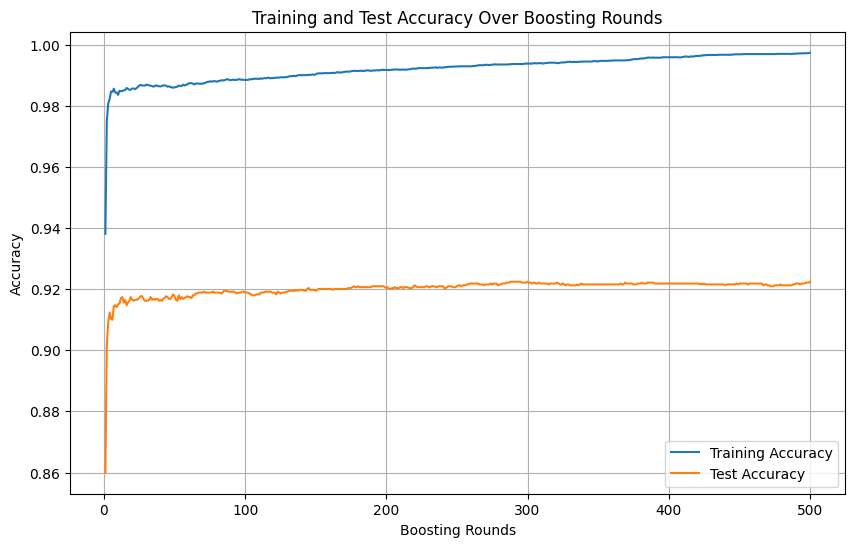

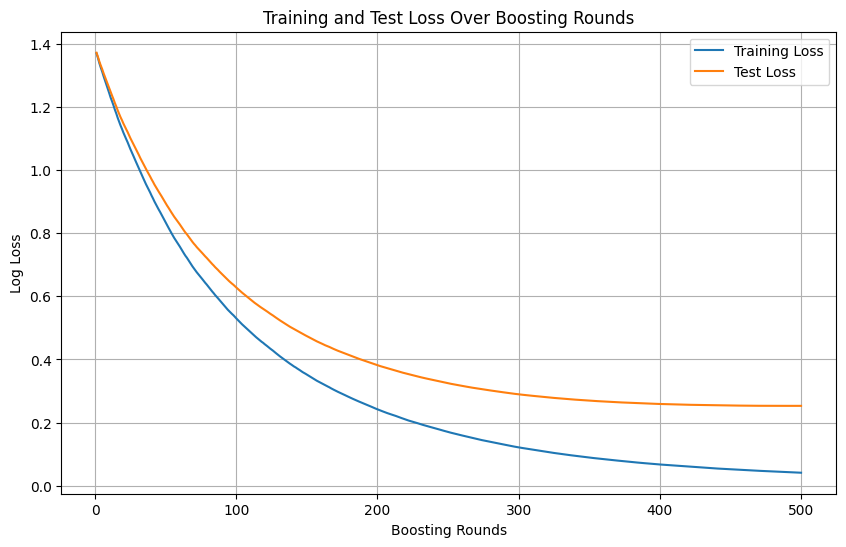

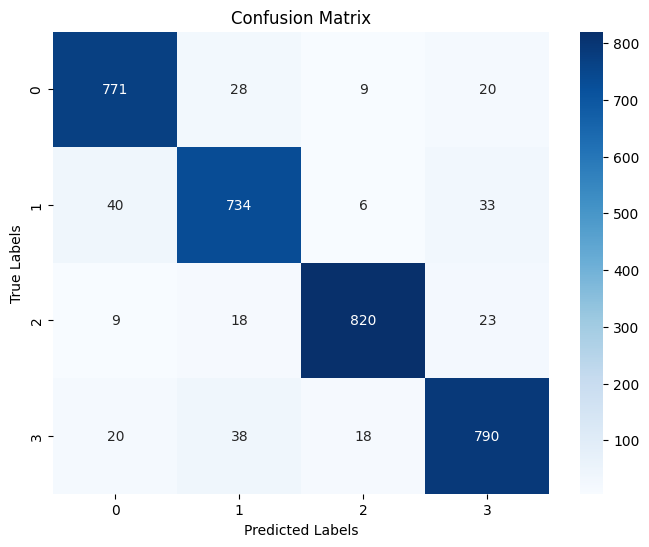

In [25]:
# Plot accuracy over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_round + 1), accuracy_callback.train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_boost_round + 1), accuracy_callback.test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Boosting Rounds')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot loss over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(evals_result['train']['mlogloss']) + 1), evals_result['train']['mlogloss'], label='Training Loss')
plt.plot(range(1, len(evals_result['eval']['mlogloss']) + 1), evals_result['eval']['mlogloss'], label='Test Loss')
plt.title('Training and Test Loss Over Boosting Rounds')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

